词汇的分布式表征

### 介绍

词汇的分布式表征，又称为词嵌入（Word Embedding），英文称作 Word2Vec，也就是把之前单词的离散表示过渡到了单词的向量表征，可以认为是自然语言处理史上的一大里程碑式的突破，使机器在理解语义层面有了质的提升，也使得众多的自然语言处理任务的性能有了大幅度的提高。

注意，本实验需要一定的深度学习前置知识，如果不熟悉此部分内容，可选择性地学习知识点，比如掌握“基于开源工具 Gensim 的 Word2Vec 训练”即可。

#### 知识点

- Word2Vec 的基本原理
- Word2Vec 训练模型 Skip-Gram 实战
- 基于开源工具 Gensim 的 Word2Vec 训练
- 更多的 Word2Vec 训练模型

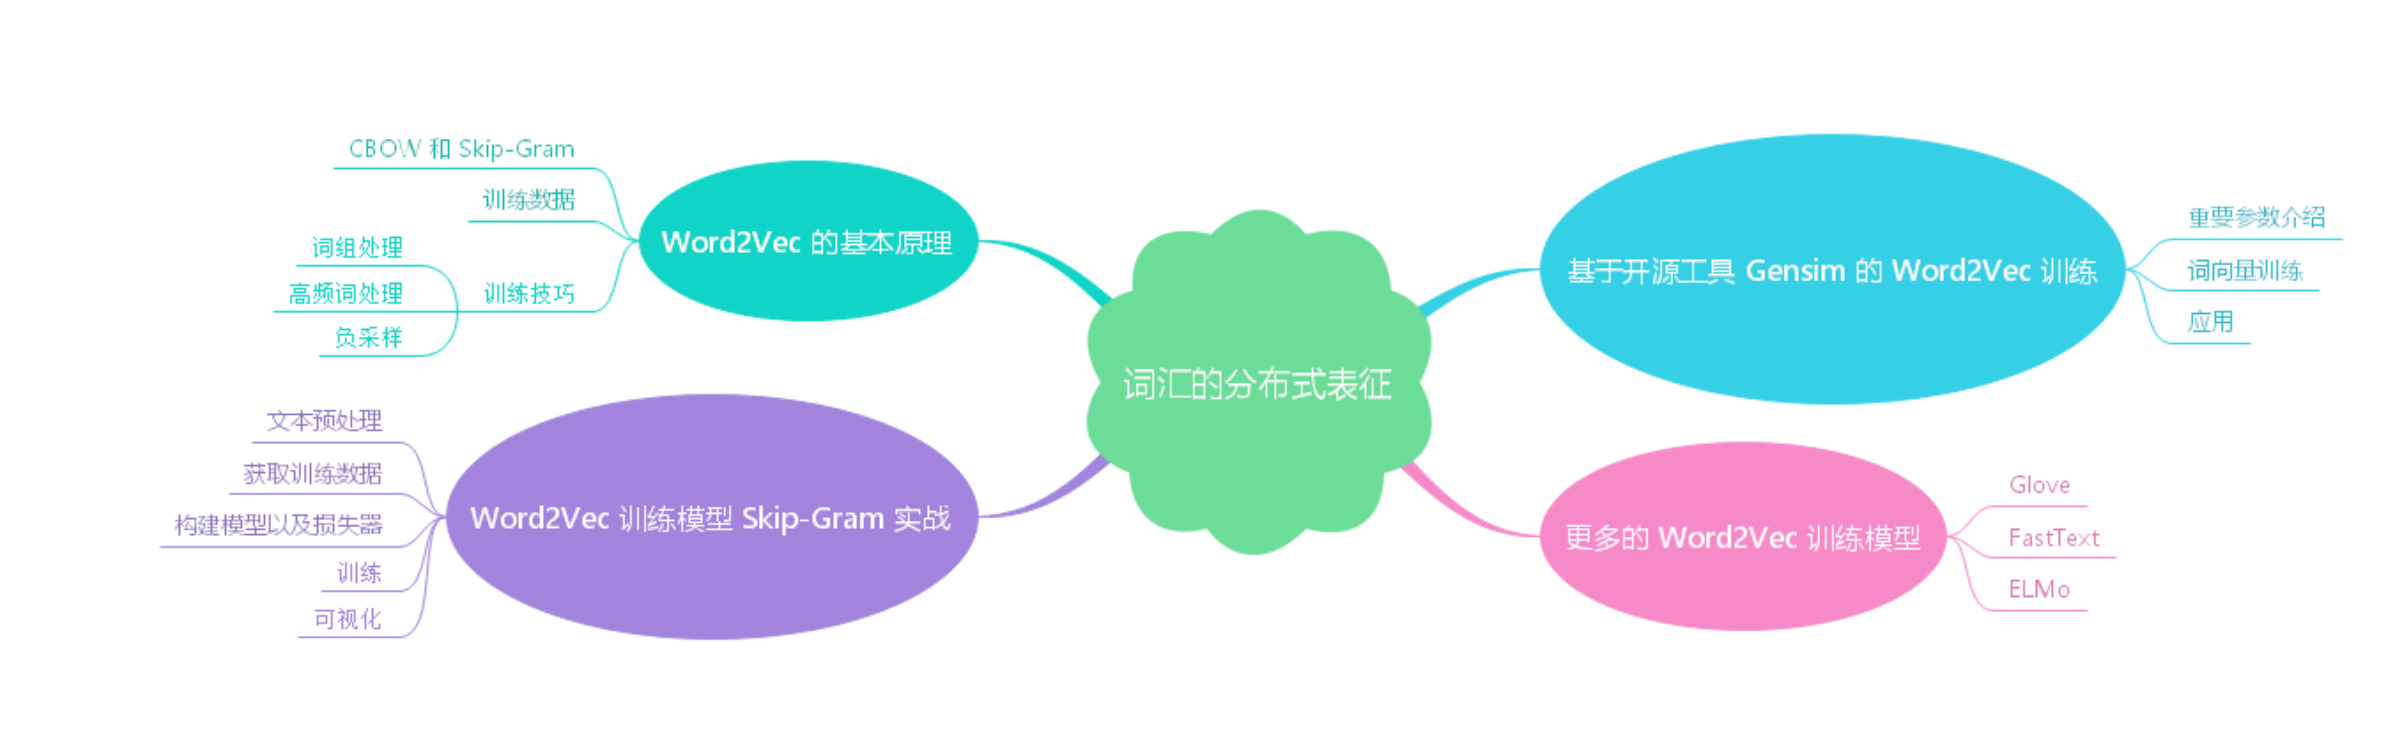

### 词向量的基本原理

在介绍词向量的原理之前，首先解释什么是词嵌入（Word Embedding）。Embedding 是一个数学专有名词，是指某个对象 X 被映射到另外一个对象 Y 中：

$$映射 f：X→Y $$

Word Embedding 则表示把词汇表中的单词映射为由实数构成的向量，比如独热编码（One-Hot）就是一种简单的 Word Embedding，每个词对应的向量维数为词典大小，词所在的索引位置为 1，其余位置均为 0。但是这种表示方法没有考虑单词之间的位置关系并且表征能力非常有限。

而 Word2Vec 是谷歌在 2013 年开源的一款用于训练词向量的工具，引起了工业界以及学术界的广泛关注。从训练的角度来说，Word2Vec 可以在百万数量级的词典和上亿数据集的资源上进行高效训练；就结果而言，其训练出的词向量能够很好地表征词义，并且能够度量两个词汇之间不同层面的词义相似度，比如，“早上”和“早晨”在意义上相似，“小猫”与“小狗”在某些特性上相似。除此以外，还能表征一些词汇间的关系，比如 king-queen ≈ man-woman ,如下图所示。

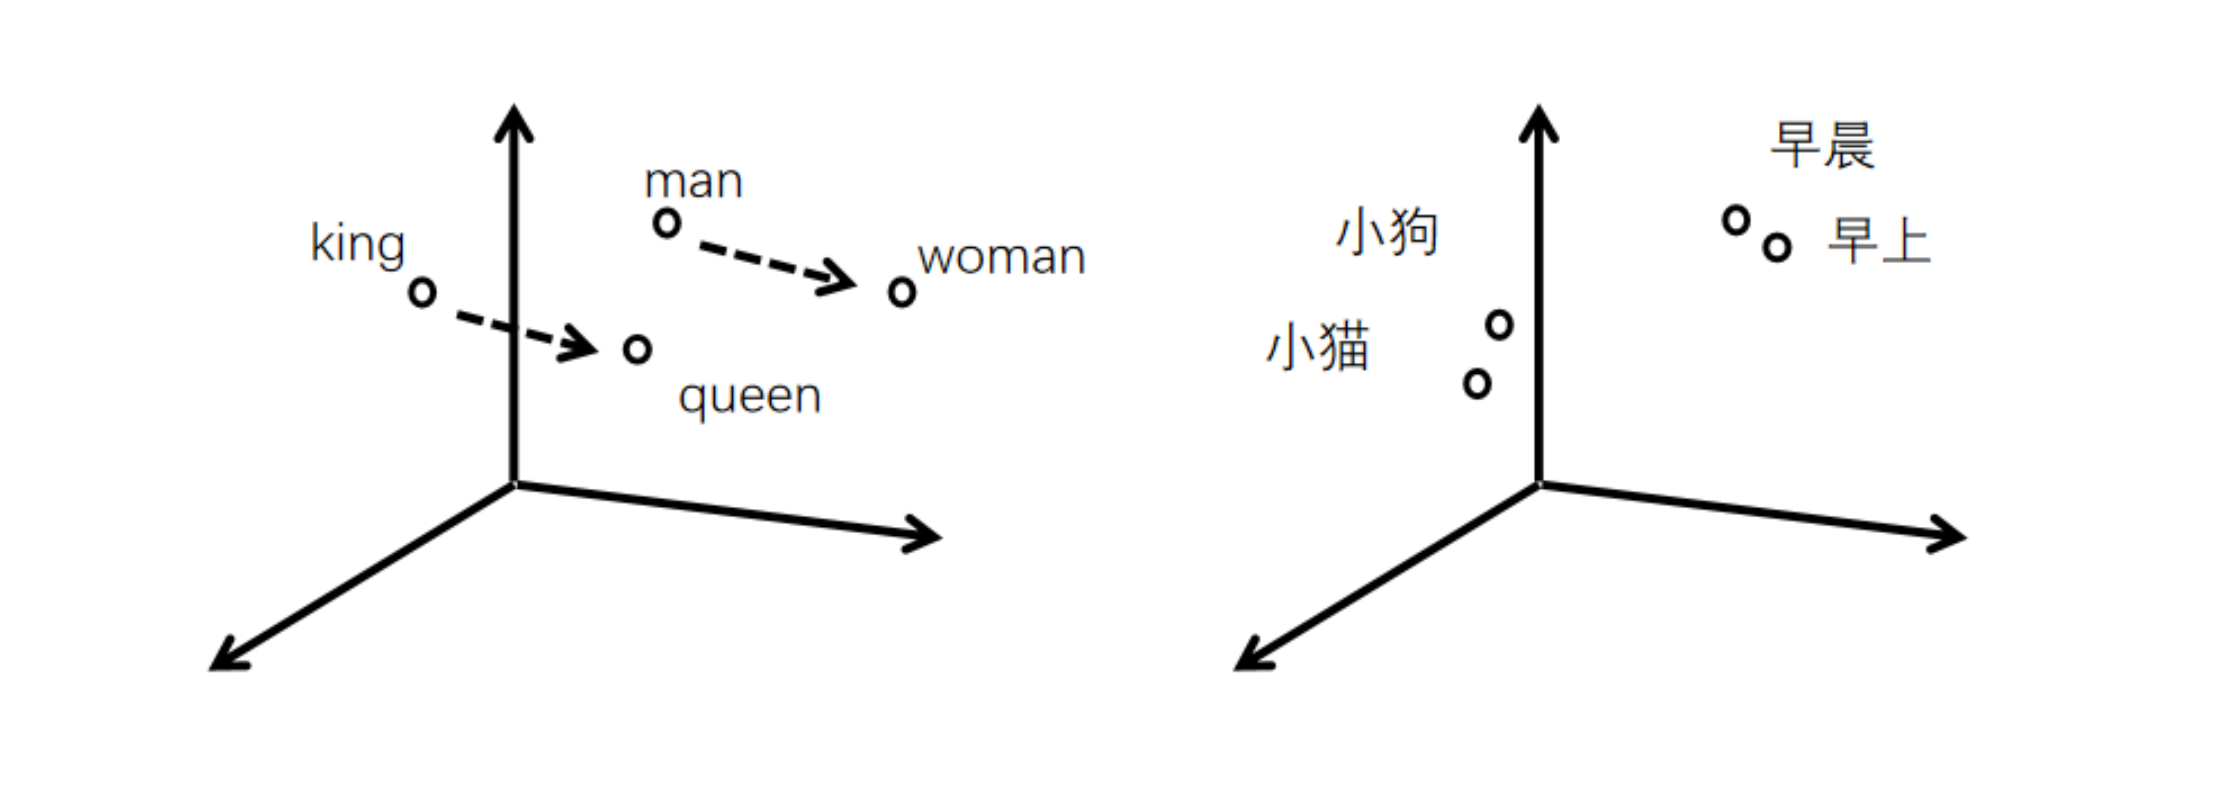

Word2Vec 包含 CBOW（Continuous Bag-of-Words）和 Skip-Gram 两种深度学习模型，直观地说，CBOW 的原理是给定上下文作为输入，经过隐藏层，来预测中心词，而 Skip-Gram 则是给定中心词作为输入，来预测上下文。以分好词并预处理好的句子“夏天/的/时候/小明/尤其/喜欢/吃/冰西瓜”为例，来看看如何为以上模型准备输入及输出数据。

针对 CBOW 模型，例如选取“喜欢”作为需要预测的中心词，那么接下来选取其上下文的词汇，在这里设定上下文窗口大小为 2，那么上下文单词分别为[“小明”，“尤其”，“吃”，“冰西瓜”]，因此最终的样本对（输入单词，输出单词）为：

- （“小明”，“喜欢”）
- （“尤其”，“喜欢”）
- （“吃”，“喜欢”）
- （“冰西瓜”，“喜欢”）

对于 Skip-Gram 而言，若也选取同样的中心词及上下文大小，则数据为：

- （“喜欢”，“小明”）
- （“喜欢”，“尤其”）
- （“喜欢”，“吃”）
- （“喜欢”，“冰西瓜”）

这个过程其实相当于给模型呈现很多上下文相关的词语对，期望其能够学习到这其中的联系。构建好样本数据，接下来需要将其数值化，即统计训练数据并构建词典表，接着根据词典中的索引，将单词表示为独热向量。假如上述句子为所有训练数据，那么对应的词典为：{0：“夏天”，1：“的”，2：“时候”，3：“小明”，4：“尤其”，5：“喜欢”，6：“吃”，7：“冰西瓜”}

以“小明”（index 为 4 的地方为 1），“喜欢”（index 为 6 的地方为 1）两个单词为例，对应的独热向量分别为：

- [0，0，0，1，0，0，0，0]
- [0，0，0，0，0，1，0，0]

之后将数值化表示的中心词以及上下文词代入模型便可进行训练。讲到这里，初识词向量的同学可能会有一个很大的疑惑，既然要训练词向量，那么这个词向量到底在哪？其实词向量就藏在模型的隐层之中，而隐层的大小便是“想要设定的词汇量*词向量维度”。

假设在某一训练数据中，词典大小为 5，设定词向量维度为 3，那么隐层的参数矩阵大小便为 5*3，模型训练好之后的参数矩阵即为词典中所有词汇的词向量表示。具体而言，矩阵中第 x 行表示的向量即为索引为 x 的词所对应的词向量。为什么可以这么认为？由于我们输入的是独热编码，经过隐层的时候，1 所在的索引位置便映射到了对应行的向量，如下图所示，第 4 个索引位置的单词对应的词向量便为 [10,12,19]。

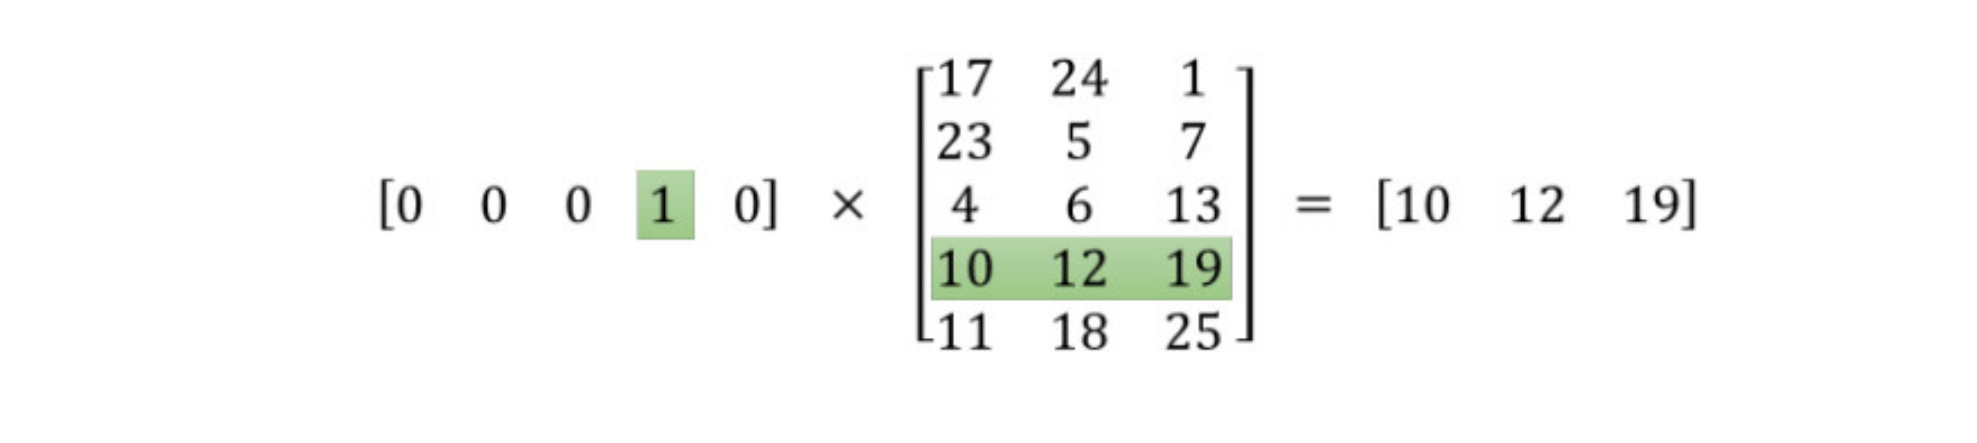

那么 Word2Vec 的原理是什么？简单来说，基于词与词之间上下文关系，应用深度学习的方法训练词向量。回想我们学习语言的过程，在遇到生词的时候，也是通过生词周边的上下文对生词词义进行预测。例如有以下几个句子：

- 夏天的时候，小明尤其喜欢吃冰西瓜。
- 夏天的时候，小明尤其喜欢吃棒冰。
- 夏天的时候，小明尤其喜欢吃XX。

其中，XX 为一个生词，其上下文与冰西瓜、棒冰的类似，那么我们可以大胆猜测 XX 也是一种冰凉解暑的食物。从这个角度而言，语境赋予了单词特定的意义，相似的单词具备相似的语境，词向量的训练思想借鉴了人类学习语言的思路。

以上简要介绍了 Word2Vec 的基本原理，其深度学习模型并不复杂，然而在实际搭建过程中，我们会发现这是一个巨大的神经网络，操作上存在诸多困难。首先，谷歌使用的词典大小是百万级别的，那么相应的输入输出向量以及隐层的矩阵规模超级巨大，因此在大规模的数据训练中，此模型的收敛速度必然会非常慢。为了解决这个工程上的难题，Word2Vec 的作者 Mikolov 等人针对训练方式提出了三个创新点：

- 将常见的单词组合（或者说词组）当作一个单词来处理：很多单词组合其实是固定的表达，如果拆分为单个词反而会影响语义，比如 New York、United Stated 等。谷歌所使用的训练数据中，单词组合（或者说词组）有三百万之多。
- 对高频词进行抽样处理：对于一些常见词汇来说，比如 the、a 等，其所对应的训练样本非常巨大，不仅消耗了大量的计算力，同时也是一种数据不平衡现象，影响训练效果。因此，对于文本中的每个词，设定一个丢弃概率，并且单词越是常见，越容易被丢弃。
- 负采样：在模型最后的输出阶段，为多分类结构，经由 Softmax 层后，我们希望所有预测单词的概率更接近于 1，而其它词对应的概率更接近于 0，因此需要对所有这些单词对应的参数进行更新，而谷歌所使用的训练样本数以亿计，利用这么大量的数据对大规模的参数进行更新，如此训练起来非常耗时。负采样的思想是，每次的训练样本是一对词语，如果其关系为中心词与上下文，则为正样本，否则为负样本，相关于一个二分类问题，从而大幅度地减小计算量。正样本可通过设置窗口大小获取中心词的周边词而得，而负样本的选择则涉及所谓的负采样，作者在论文中指出，对于小规模数据，一般选择 5-20 个负样本会比较好，对于大规模数据集可以仅选择 2-5 个负样本。假设词典总大小为 10000，选取 5 个负样本进行相关的参数更新，再加上正样本，相当于计算量为原来的 6/10000。

那么，按照什么标准选择负样本呢？在这里，一个单词被选作负样本的概率也与它的出现频次相关，出现频次越高的单词越容易被选作负样本。某个单词被选中的概率计算表达式如下，其中 $P(w_i)$ 表示单词 $w_i$ 的被当作负样本的概率大小， $f(w_i)$ 表示其出现频率，n 表示词典大小：

$$P(w_i) = \frac{f(w_i)^{3/4}}{\sum_{j=1}^n{f(w_j)^{3/4}}} $$

在结合负采样后，Word2Vec 的训练流程如下，首先获取（中心词，周边词）样本对（当然这里的样本对中的周边词也有可能是由负样本采得到的噪声词），转化为独热向量，两个词向量矩阵为神经网络中的隐层参数矩阵（一开始随机初始化），大小一致，中心词和周边词分别经过这两个词向量矩阵后得到两个词向量，若两词汇真为上下文关系，即为正样本，否则为负样本，因此为二分类模型，只需要经过 Sigmoid 运算即可。

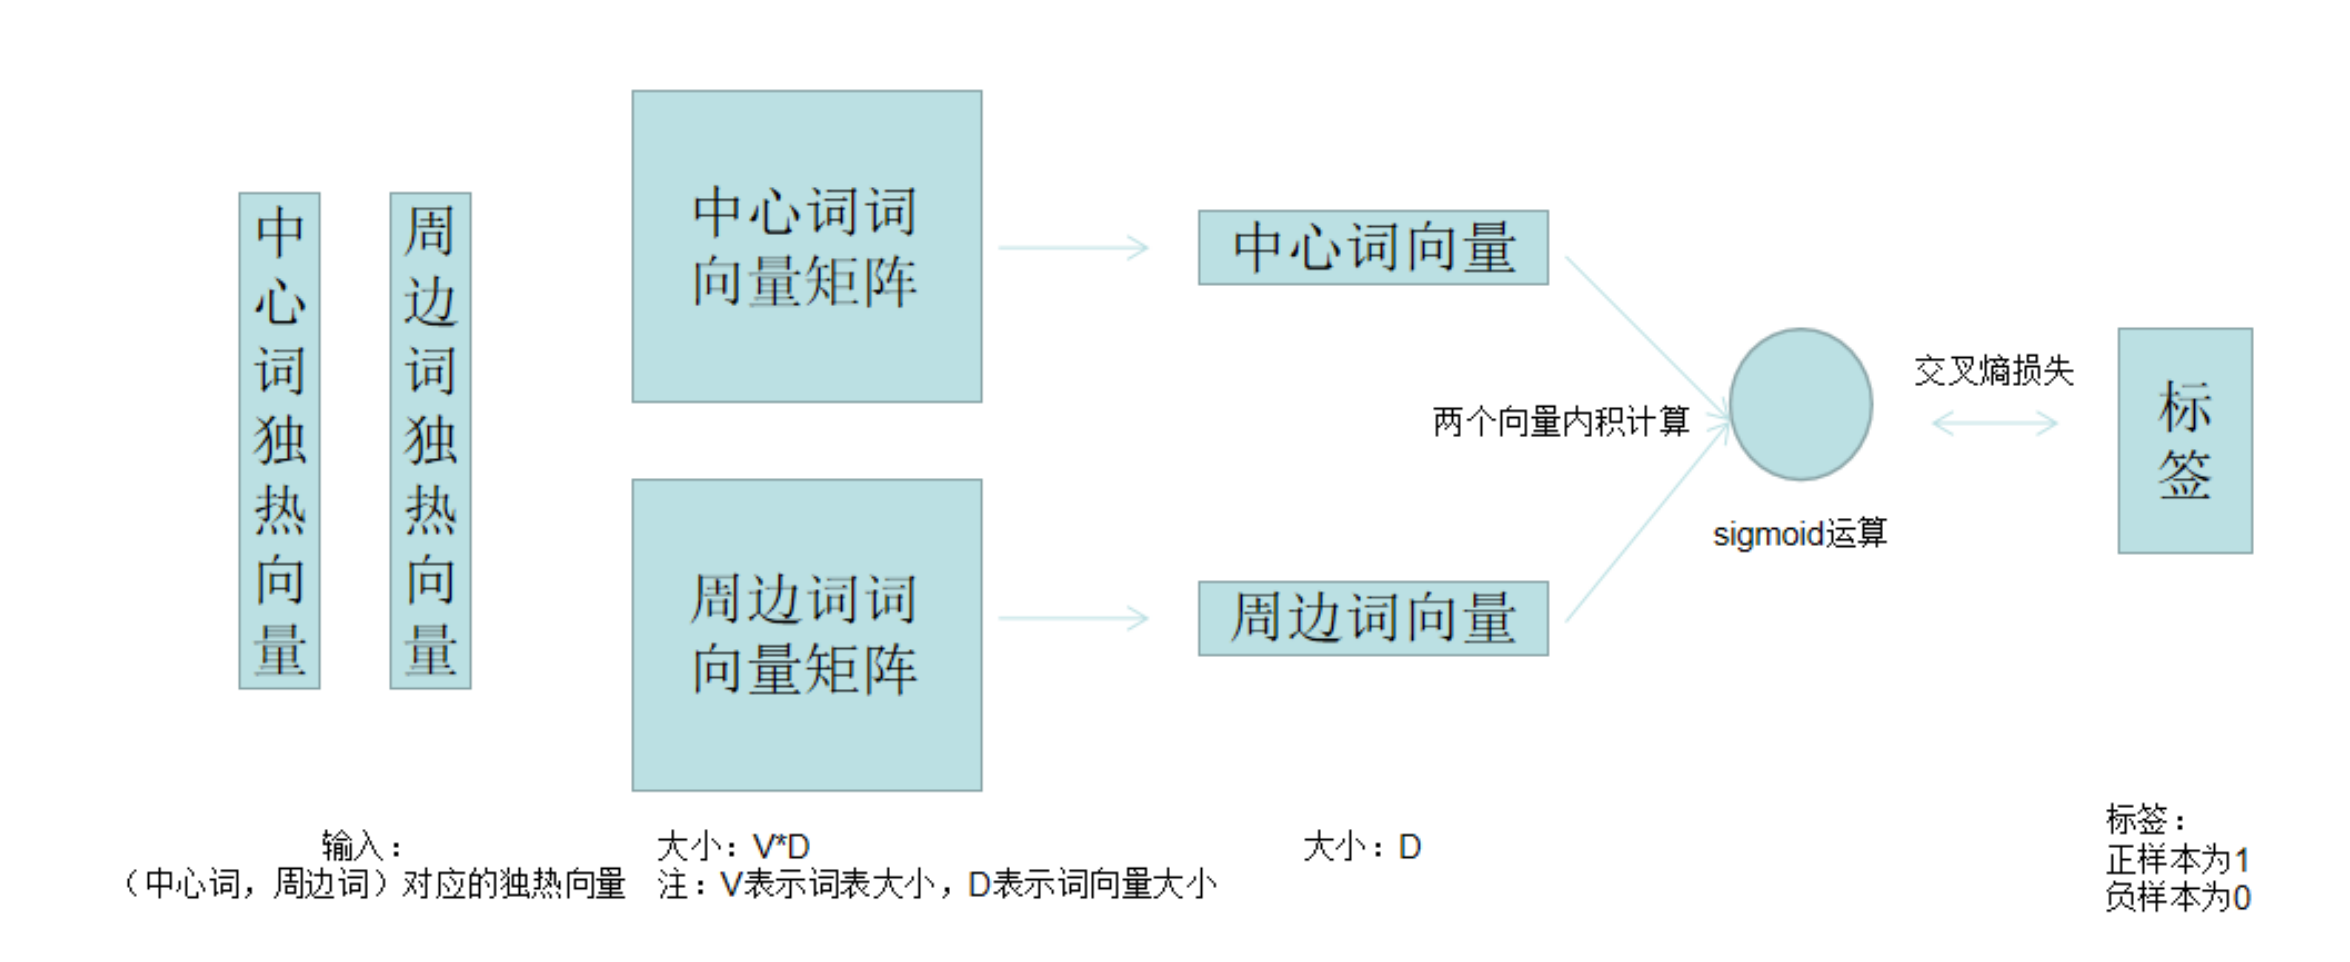

### Word2Vec 训练模型 Skip-Gram 实战

接下来我们利用深度学习框架 PyTorch 搭建基于负样本采样的 Skip-gram 结构，训练并可视化词向量，主要步骤如下：

- 文本预处理，比如去除特殊符号、标点符号等。
- 获取训练数据，也就是（输入词，目标词）样本对，当然也包括负样本，并且构建批次化训练数据的迭代器。
- 构建模型以及损失器。
- 词向量训练。
- 词向量可视化。

注意，在 Skip-Gram 模型中，我们这里统一把“周边词”称为“目标词”。

作为演示，这里用于词向量训练的文本数据很简单，如下：

<i class="fa fa-arrow-circle-down" aria-hidden="true"> 教学代码：</i>

In [1]:
text = "i like dog i like cat i like animal dog cat animal apple cat dog like dog fish milk like dog \
cat eyes like i like apple apple i hate apple i movie book music like cat dog hate cat dog like"

<i class="fa fa-arrow-circle-down" aria-hidden="true"> 动手练习：</i>

训练词向量相关的参数设置：

In [3]:
# 基本的参数设置
EMBEDDING_DIM = 2  # 词向量维度
PRINT_EVERY = 1000  # 每训练多少步可视化一次
EPOCHS = 1000  # 训练的轮数
BATCH_SIZE = 5  # 每一批训练数据中输入词的个数
N_SAMPLES = 3  # 负样本大小
WINDOW_SIZE = 5  # 周边词窗口大小
FREQ = 0  # 去除低频词的阈值
DELETE_WORDS = False  # 是否进行高频词抽样处理

接着对文本进行简单的预处理，包括大小写转换，去除低频词，在实践中针对真实数据，还需要依据文本情况进行更复杂的处理，比如多文本的处理、特殊符号的处理、词形还原等。

In [4]:
from collections import Counter


# 文本预处理
def preprocess(text, FREQ):
    text = text.lower()  # 转小写
    words = text.split()  # 分词
    # 去除低频词
    word_counts = Counter(words)  # 计算词频
    trimmed_words = [word for word in words if word_counts[word] > FREQ]
    return trimmed_words

In [ ]:
words = preprocess(text, FREQ)
words

为每个词汇分配一个 id，并将文本数据转化为 id 值：

In [ ]:
vocab2id, id2vocab = {}, {}
for w in words:
    if w not in vocab2id:
        vocab2id[w] = len(vocab2id)
        id2vocab[len(id2vocab)] = w
# 将文本转化为数值
id_words = [vocab2id[w] for w in words]
id_words

由于在对高频词进行抽样处理以及负采样过程中都涉及到单词的出现频次信息，因此可提前计算单词的频次分布。

In [ ]:
import numpy as np
import torch

int_word_counts = Counter(id_words)
total_count = len(id_words)  # 总频次
word_freqs = {w: c/total_count for w,
              c in int_word_counts.items()}  # 计算每个单词的出现频率

# 负样本抽样中，计算某个单词被选中的概率分布
unigram_dist = np.array(list(word_freqs.values()))
noise_dist = torch.from_numpy(
    unigram_dist ** (0.75) / np.sum(unigram_dist ** (0.75)))

根据丢弃率丢弃文本中的部分单词（在本例中 `DELETE_WORDS = False` ，因为语料本身很少）：

In [ ]:
import random

if DELETE_WORDS:
    t = 1e-5
    prob_drop = {w: 1 - np.sqrt(t/word_freqs[w])
                 for w in id_word_counts}  # 每个单词被丢弃的概率，与词频相关
    train_words = [w for w in id_words if random.random() >
                   prob_drop[w]]  # 根据丢弃概率保留训练单词
else:
    train_words = id_words

获取目标词汇，即输入词的周边词。

In [ ]:
def get_target(words, idx, window_size):
    # idx 表示输入词在单词序列中的下标
    # 确定目标词的起止范围
    start_point = idx - window_size if (idx - window_size) > 0 else 0
    end_point = idx + window_size
    targets = words[start_point:idx] + words[idx + 1:end_point + 1]  # 获取目标词
    return targets

接下来对数据进行批次化处理，构建批迭代器，这里需要注意的一点是，对于每一个输入词而言，虽然设置的 WINDOW_SIZE 一致，但是周边词的多少也并非一致，这是由于词汇本身的上下文大小不一致，比如位于 text 最初始位置的 “I” 不存在上文，而位于末位的 “like” 没有下文，在中间的词汇则有更多的上下文。

In [ ]:
def get_batch(words, batch_size, window_size):
    n_batches = len(words)//batch_size  # 有多少个批次
    words = words[:n_batches * batch_size]  # 取可以整除批次的训练数据
    # 隔一个 BATCH_SIZE 大小遍历数据
    # 注意，这里的 BATCH_SIZE 并非训练过程中一批数据的大小
    # 而是一批训练数据中输入词汇的多少，因此真正的训练数据是 BATCH_SIZE * 2 * WINDOW_SIZE
    for idx in range(0, len(words), batch_size):
        batch_x, batch_y = [], []  # 输入词及目标词
        batch = words[idx:idx + batch_size]  # 一个 batch 中所取的输入词
        for j in range(batch_size):
            x = batch[j]  # 获取输入词
            y = get_target(batch, j, window_size)  # 获取目标词
            # 一个输入词对应多个目标词，因此复制输入词个数，使两者一一对应，再放入批数据中
            batch_x.extend([x] * len(y))
            batch_y.extend(y)  # 将目标词放入批数据中
        yield batch_x, batch_y

以上过程主要包括参数设置、文本的预处理、输入输出数据的构建，属于一些基本的准备工作，接下来进入模型的搭建阶段，首先定义基于负采样的 Skip-Gram 模型，主要包括词向量层的定义及初始化、输入词、目标词以及负样本的前向过程。

In [ ]:
from torch import nn, optim


# Skip-gram 模型的构建
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist):
        super(SkipGramNeg, self).__init__()
        self.n_vocab = n_vocab  # 词典大小
        self.n_embed = n_embed  # 词向量维度
        self.noise_dist = noise_dist  # 负样本抽样中，计算某个单词被选中的概率分布
        # 定义词向量层，包括输入词及目标词分别对应的词向量层，参数矩阵大小一样
        self.in_embed = nn.Embedding(n_vocab, n_embed)
        self.out_embed = nn.Embedding(n_vocab, n_embed)
        # 词向量层参数初始化
        #self.in_embed.weight.data.uniform_(-1, 1)
        #self.out_embed.weight.data.uniform_(-1, 1)
    # 输入词的前向过程，即获取输入词的词向量

    def forward_input(self, input_words):
        input_vectors = self.in_embed(input_words)
        return input_vectors
    # 目标词的前向过程，即获取目标词的词向量

    def forward_output(self, output_words):
        output_vectors = self.out_embed(output_words)
        return output_vectors
    # 负样本词的前向过程，即获取噪声词（负样本）的词向量

    def forward_noise(self, batch_size, n_samples):
        # 从词汇分布中采样负样本
        noise_words = torch.multinomial(self.noise_dist,
                                        batch_size * n_samples,
                                        replacement=True)
        noise_vectors = self.out_embed(noise_words).view(
            batch_size, N_SAMPLES, self.n_embed)
        return noise_vectors

In [ ]:
定义损失函数，重点在于将输入词向量、输出词向量（目标词向量）以及负样本词向量转化成合成的维度形式，并且综合目标词损失以及负样本损失。

In [ ]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self, n_embed):
        super(NegativeSamplingLoss, self).__init__()
        self.n_embed = n_embed

    def forward(self, input_vectors, output_vectors, noise_vectors):
        batch_size, _ = input_vectors.shape
        # 将输入词向量与目标词向量作维度转化处理
        input_vectors = input_vectors.view(batch_size, self.n_embed, 1)
        output_vectors = output_vectors.view(batch_size, 1, self.n_embed)
        # 目标词损失
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log()
        out_loss = out_loss.squeeze()
        # 负样本损失
        noise_loss = torch.bmm(noise_vectors.neg(),
                               input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)
        # 综合计算两类损失
        return - (out_loss + noise_loss).mean()

模型、损失函数及优化器初始化。

In [ ]:
model = SkipGramNeg(n_vocab=len(vocab2id),
                    n_embed=EMBEDDING_DIM, noise_dist=noise_dist)
criterion = NegativeSamplingLoss(n_embed=EMBEDDING_DIM)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

以上过程将数据部分以及模型部分都处理完毕，接下来进行数据训练，主要包括数据批次化、计算损失及可视化损失以及梯度回传。

In [ ]:
steps = 0
for e in range(EPOCHS):
    # 获取输入词以及目标词
    for input_words, target_words in get_batch(train_words, BATCH_SIZE, WINDOW_SIZE):
        steps += 1
        inputs, targets = torch.LongTensor(
            input_words), torch.LongTensor(target_words)  # 转化为 tensor 格式
        # 输入词、目标词以及噪声词向量
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        batch_size, _ = input_vectors.shape
        noise_vectors = model.forward_noise(batch_size, N_SAMPLES)
        # 计算损失
        loss = criterion(input_vectors, output_vectors, noise_vectors)
        # 打印损失
        if steps % PRINT_EVERY == 0:
            print("loss：", loss)
        # 梯度回传
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
接下来对所训练出来的词向量进行可视化，由于我们设置的 EMBEDDING_DIM 为 2，因此可以直接在二维平面上展示，只需要取出模型中 in_embed 层所对应的参数矩阵即可。

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
for i, w in id2vocab.items():
    vectors = model.state_dict()["in_embed.weight"]  # 获取输入词的词向量矩阵
    x, y = float(vectors[i][0]), float(vectors[i][1])
    plt.scatter(x, y)
    plt.annotate(w, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')
plt.show()

思考：观察词汇的表征图，分析训练效果，也可以增加训练数据或者调节参数，进行更多尝试。

### 基于开源工具 Gensim 的 Word2Vec 训练

Gensim 中的 Word2Vec 库封装了谷歌 c 语言版本的 Word2Vec 模型，在实际应用中，我们可以在 Python 中方便地调用此库，轻松实现对自定义语料的词向量训练。具体而言，与训练相关的所有参数都在 `gensim.models.word2vec.Word2Vec` 这个类中，这里首先针对几个重要参数进行简要介绍，内容来自于其 API 文档：

- `Sentences`：用于训练词向量的语料，可以是一个列表，当数据量较大时也可以从文件中遍历读出。
- `Size`：词向量的维度，默认值为 100。这里的取值一般与语料大小相关，如果语料库较大，建议适当增大维度。
- `window`：即上下文窗口大小，默认值为 5，可以根据实际的情况如训练速度要求、语料大小等，进行动态调整。
- `sg`：即 Word2Vec 中两个模型的选择，默认为 0，表示 CBOW 模型，更改为 1 则是 Skip-Gram 模型。
- `negative`：使用负采样时负样本的个数，推荐取值在[5,20]之间。
- `min_count`：需要计算词向量的词的最小词频，可以去掉一些很生僻的低频词，默认是 5。如果是小语料，可以调低此值。
- `iter`：随机梯度下降法中迭代的最大次数，默认是 5。对于大语料，可以增大这个值。
- `alpha`：在随机梯度下降法中迭代的初始步长，默认是 0.025。

接下来我们以《红楼梦》一书为语料进行词向量训练。

In [ ]:
import jieba
import re


# 读取数据
def preprocess_data(file_path):
    texts = []
    with open(file_path, "r", encoding="utf-8") as f:
        for text in f.readlines():
            text = re.sub("[^\u4e00-\u9fa5。？．，！：]", "",
                          text.strip())  # 只保留中文以及基本的标点符号
            text_splited = re.split("[。？．，！：]", text)  # 按照基本的标点符号进行分块
            texts += text_splited
    texts_cuted = [jieba.lcut(text)
                   for text in texts if text is not ""]  # 去除空字符且分词
    return texts_cuted

In [ ]:
!wget -nc "https://labfile.oss.aliyuncs.com/courses/3205/hongloumeng.txt"
texts_cuted = preprocess_data("hongloumeng.txt")  # 处理数据《红楼梦》一书

In [ ]:
训练词向量：

In [ ]:
from gensim.models import word2vec
hongloumeng_model = word2vec.Word2Vec(
    texts_cuted, min_count=2, window=5, size=100)

通过以上简单的步骤便训练好了一个基于《红楼梦》一书的词向量库，接下来可作如何应用？可以直接获取某词的词向量：

In [ ]:
print(hongloumeng_model["黛玉"])

获取某词 topN 的相似词:

In [ ]:
hongloumeng_model.wv.similar_by_word("黛玉", topn=10)

原来黛玉和宝钗的关系反而是最近的，前 10 名里竟然没有宝玉。

In [ ]:
hongloumeng_model.wv.similar_by_word("宝玉", topn=10)

和宝玉关系相近的前 10 名果然大部分是女性，不过竟然是凤姐居前 10 之首。

使用 `wv.save_word2vec_format()` 保存词向量文件，方便下次调用。

In [ ]:
hongloumeng_model.wv.save_word2vec_format("hongloumeng_model.bin", binary=True)

接下来还有《倚天屠龙记》一书，并且有相关人名的词典可导入 jieba，提高分词效果，大家可以做一些有趣的分析与实验，比如 "张无忌" 到底和谁关系更近，"周芷若" 还是 "赵敏"？

In [ ]:
# 处理数据《倚天屠龙记》一书
!wget -nc "https://labfile.oss.aliyuncs.com/courses/3205/wuxia_people.txt"
!wget -nc "https://labfile.oss.aliyuncs.com/courses/3205/yitiantulongji.txt"
jieba.load_userdict("wuxia_people.txt")# 导入金庸武侠中的人物名，防止分词出错
yitiantulongji_model = word2vec.Word2Vec(preprocess_data(
    "yitiantulongji.txt"),min_count=2, window=5, size=100)

In [ ]:
yitiantulongji_model.wv.similar_by_word("张无忌", topn=10)

In [ ]:
yitiantulongji_model.wv.similar_by_word("王重阳", topn=10)

In [ ]:
yitiantulongji_model.wv.similar_by_word("明教", topn=10)

可以对感兴趣的人物、武功、门派做更多数据分析哟。

### 更多的 Word2Vec 训练模型

虽然 Word2Vec 相较于早期的词汇离散式表征有了突破性进步，但还是存在一些缺陷，比如没有利用全局统计信息（只有窗口范围的词汇相关信息），没有考虑到词形信息，对未登录词或者多义词没有很好的解决方案等。这里主要介绍，后续的研究者们基于以上缺点，提出的一些改进版本的词表示模型：

- GloVe： 全称 Global Vectors for Word Representation，由斯坦福 NLP 研究小组在 2014 年提出，是一种基于全局词频统计的词向量生成方法。作者指出，一般的 Word2Vec 模型训练方法只关注词汇的上下文信息而忽略了词与词之间的共现信息，因此缺少全局性，而 GloVe 在 Word2Vec 捕捉局部信息的基础上，还结合了全局矩阵分解方法（Matrix Factorization），其训练而得的词向量在很多自然语言处理任务上都有效果提升。
- FastText：输入词的序列，输出这个词序列属于不同类别的概率。模型架构和 Word2Vec 中的 CBOW 模型很类似。不同之处在于，FastText 预测标签，而 CBOW 模型预测中心词。为了更好地获取词形信息以及解决未登录词问题，FastText 提出了基于子词信息的词汇表示形式（比如 apple 由 app，ppl ple 构成）；为了改善运行时间，FastText 模型使用了层次 Softmax 技巧，建立在哈弗曼编码的基础上，对标签进行编码，能够极大地缩小模型预测目标的数量。
- ELMo：Peters 等人在 2018 年提出的词向量训练方法，他们认为一个好的词向量需要兼具语义及语法的复杂特点和随着语言环境而改变的能力。而 ELMo 的核心正是语言模型任务，通过搭建一个深层的双向 LSTM 网络结构，进行大规模语料的训练，其原始词向量及一系列双向隐层状态特征的线性组合便可以是词表征。这个过程以人类解读词汇的角度来理解也很直观，举个例子，对于句子“我/在/吃/土豆”中的词汇“吃”，从前往后阅读此句，可理解为“这是我在施行的一个动作”，从后往前阅读，可认为是“对于土豆施行的动作”，对应 LSTM 网络的双向隐层特征，而词汇“吃”本身也可解读到一种语义信息，对应原始词向量，综合三者，人脑便解读出了“吃”在这个句子中的特定内涵。正是基于这种解读方式，ELMo 所考虑的是，词汇在特定句子中的特定含义。

### 实验总结

词向量是自然语言处理中的一大难点及重点，理解了词向量，说明你已经入门自然语言处理啦！本实验主要介绍了以下知识点：

- Word2Vec 的基本原理
- Word2Vec 训练模型 Skip-Gram 实战
- 基于开源工具 Gensim 的 Word2Vec 训练
- 更多的 Word2Vec 训练模型

本实验中涉及较多深度学习知识，如果是对于无基础的同学来说稍有难度，建议优先学习如何应用工具训练词向量，在有了一定的基础之后再来看相关的手工词向量训练代码以加深对训练模型的理解。

本实验学习了词汇的表示，进一步地，如何表征一个文本呢？我们将在下一实验中学习如何应用多种方式表示文本。

<hr><div style="color: #999; font-size: 12px;"><i class="fa fa-copyright" aria-hidden="true"> 本课程内容版权归蓝桥云课所有，禁止转载、下载及非法传播。</i></div>